In [1]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [3]:
from matplotlib.colors import LinearSegmentedColormap,ListedColormap

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import t
import math
import re

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import binary_cross_entropy

In [6]:
from psyke import Extractor, Clustering, EvaluableModel
from psyke.extraction.hypercubic.strategy import AdaptiveStrategy
from psyke.extraction.hypercubic import Grid, FeatureRanker
from psyke.tuning.orchid import OrCHiD
from psyke.tuning.crash import CRASH
from psyke.utils.logic import pretty_theory
from psyke.utils import Target

In [7]:
# functions to print scores for the generated rules
def print_scores(scores):
    print(f'Classification accuracy = {scores[EvaluableModel.ClassificationScore.ACCURACY][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.ACCURACY][1]:.2f} (BB)\n'
          f'F1 = {scores[EvaluableModel.ClassificationScore.F1][0]:.2f} (data), '
          f'{scores[EvaluableModel.ClassificationScore.F1][1]:.2f} (BB)')

def get_scores(extractor, test, predictor):
    return extractor.score(test, predictor, True, True, False, task=EvaluableModel.Task.CLASSIFICATION,
                           scoring_function=[EvaluableModel.ClassificationScore.ACCURACY,
                                             EvaluableModel.ClassificationScore.F1])

In [8]:
# function to compute performance metrics
def get_results(y_pred, y_test):
    a   = accuracy_score(y_test, y_pred)
    ba  = balanced_accuracy_score(y_test, y_pred)
    p   = precision_score(y_test, y_pred)
    r   = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    roc = roc_auc_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return [a, ba, p, r, f1, roc, mcc]

In [9]:
# function to compute accuracy with respect to a rule-based system
def get_relative_accuracy(y_test, y_rule, y_pred):
    return sum((y_test == y_rule) & (y_rule == y_pred.round())) / sum(y_test == y_rule)

In [10]:
# function to generate a summary table
def get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test):
    res = pd.DataFrame(index = scores_ml.columns, columns = ["ML_mean","ML_std","KB-ML_mean","KB-ML_std"])
    res["ML_mean"] = scores_ml.mean().round(3)
    res["ML_std"] = scores_ml.std().round(3)
    res["KB-ML_mean"] = scores_kbml.mean().round(3)
    res["KB-ML_std"] = scores_kbml.std().round(3)
    res["p-value"] = np.nan
    res["corr_p-value"] = np.nan
    for c in res.index:
        difference = scores_ml[c].values - scores_kbml[c].values
        # uncorrected paired t-test p-value
        t_stat_uncorrected = np.mean(difference) / np.sqrt(np.var(difference, ddof=1) / n)
        p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), n_1)
        res.loc[c,"p-value"] = p_val_uncorrected.round(4)
        # corrected paired t-test p-value
        t_stat, p_val = compute_corrected_ttest(difference, n_1, n_train, n_test)
        res.loc[c,"corr_p-value"] = p_val.round(3)
    return res

In [11]:
# function to correct the standard deviation using Nadeau and Bengio's approach.
def corrected_std(differences, n_train, n_test):
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std

# function to compute right-tailed paired t-test with corrected variance.
def compute_corrected_ttest(differences, df, n_train, n_test):
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, target, mask, factor):
        criterion = nn.BCELoss()
        loss = criterion(output, target)
        high_cost = factor*binary_cross_entropy(output, target, weight = mask.float())
        return loss + high_cost

In [13]:
# function to parse rules from theories
def parse_rules(rule_string):
    opposite_signs = {
        '<': '>',
        '>': '<',
        '<=': '>=',
        '>=': '<=',
        '=<': '=>',
        '=>': '=<',
    }
    rules = []
    # predicate with rules
    rule_pattern = re.compile(r"'Outcome'\((.*?)\)\s:-\s*(.*?)\.($|\s)")
    # final predicate with no rules
    rule_pattern_end = re.compile(r"'Outcome'\((.*?)\)\.")
    # rule condition
    condition_pattern = re.compile(r'([a-zA-Z]+)\s*([=<>]+)\s*([0-9.-]+)')
    # rule interval
    interval_pattern = re.compile(r"([a-zA-Z]+)\s+in\s+\[([-+]?\d*\.?\d+),\s*([-+]?\d*\.?\d+)\]")
    for match in rule_pattern.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        conditions_str = match.group(2).strip()
        conditions = []
        # condition with less than / greater than
        for condition_match in condition_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            operation = condition_match.group(2)
            threshold = float(condition_match.group(3))
            conditions.append({
                "variable": variable,
                "operation": operation,
                "threshold": threshold
            })
        # condition with interval
        for condition_match in interval_pattern.finditer(conditions_str):
            variable = condition_match.group(1)
            lower_bound = float(condition_match.group(2))
            upper_bound = float(condition_match.group(3))
            conditions.extend([
                {"variable": variable,
                "operation": ">=",
                "threshold": lower_bound},
                {"variable": variable,
                "operation": "<=",
                "threshold": upper_bound}           
            ]) 
        rules.append({
            "conditions": conditions,
            "outcome": outcome
        })
    # rule with no conditions
    for match in rule_pattern_end.finditer(rule_string):
        outcome = match.group(1).strip().split()[-1]
        rules.append({
            "conditions": [],
            "outcome": outcome
        })
    return rules

In [14]:
def get_kb_rules():
# define rules from the knowledge base
    return [ {"conditions" : [{"variable" : "BMI",
                                      "operation" : "<=",
                                      "threshold" : 25},
                                     {"variable" : "Glucose",
                                      "operation" : "<=",
                                      "threshold" : 100}],
                     "outcome" : "healthy"},
                    {"conditions" : [{"variable" : "BMI",
                                      "operation" : ">=",
                                      "threshold" : 30},
                                     {"variable" : "Glucose",
                                      "operation" : ">=",
                                      "threshold" : 126}],
                     "outcome" : "diabetes"}]

In [15]:
# update thresholds with scaled values - TO DO: update to make more general
def update_kb_scaled(kb_rules_og, scaler):
    rs = scaler.transform(np.array([[0, 100, 0, 0, 0, 25, 0, 0],[0, 126, 0, 0, 0, 30, 0, 0]]))
    kb_rules = kb_rules_og.copy()
    # update rules
    kb_rules[0]['conditions'][0]['threshold'] = round(rs[0][5],2)
    kb_rules[1]['conditions'][0]['threshold'] = round(rs[1][5],2)
    kb_rules[0]['conditions'][1]['threshold'] = round(rs[0][1],2)
    kb_rules[1]['conditions'][1]['threshold'] = round(rs[1][1],2)
    return kb_rules

In [16]:
# function to collect all variables in rules and corresponding thresholds
def get_thresholds(all_rules, test):
    # all variables in rules
    variables = {condition['variable'] for rule in all_rules for condition in rule['conditions']}
    thresholds = {variable: [] for variable in variables}
    # all thresholds in rules
    for rule in all_rules:
        for condition in rule['conditions']:
            thresholds[condition["variable"]].append(condition["threshold"])
    for key in thresholds:
        thresholds[key].append(round(test[key].min(),2))
        thresholds[key].append(round(test[key].max(),2))
        thresholds[key] = sorted(set(thresholds[key])) 
    return thresholds

In [25]:
# add intervals to rules in rule sets
def add_interval(rules, thresholds):
    # variables across all rule sets
    variables = thresholds.keys()
    # variables in this particular rule set
    vars_in_rule_set = list(set([cond['variable'] for rule in rules for cond in rule['conditions']]))
    # record intervals covered by rules
    coverage = {variable: np.full((len(thresholds[variable])-1), False) for variable in vars_in_rule_set}
    for rule in rules:
        # for each rule initialise an interval dictionary and a mask dictionary 
        #(the mask identifies the positions that will be set to 1)
        vars_in_rule = list(set([cond['variable'] for cond in rule['conditions']]))
        intervals = {variable: np.zeros(len(thresholds[variable])-1).astype("int") for variable in variables}
        mask = {variable: np.full(len(intervals[variable]), True) for variable in variables} 
        # any or the predicates with conditions
        if len(rule['conditions']) != 0:
            # parse all conditions of the rule and update the mask
            for condition in rule['conditions']:
                var = condition['variable']
                if ">" in condition['operation']:
                    mask[var] = mask[var]*(np.arange(len(intervals[var])) >= thresholds[var].index(condition['threshold']))
                elif "<" in condition['operation']:
                    mask[var] = mask[var]*(np.arange(len(intervals[var])) < thresholds[var].index(condition['threshold']))
            # remove intervals already included in previous rules
            for var in vars_in_rule_set:
                mask[var] = mask[var]*(~(mask[var]*coverage[var]))
            # add conditions of the current rule to the coverage
            for var in vars_in_rule:
                coverage[var] = (coverage[var] | mask[var])    
            # set intervals
            for var in variables:
                intervals[var][mask[var]] = 1 
        # last predicate of the theory without conditions
        else:
            #include intervals not included in other rules
            for var in vars_in_rule_set:
                mask[var] = ~(coverage[var]) 
            # set intervals
            for var in variables:
                intervals[var][mask[var]] = 1 
        # concatenate all intervals into a single vector
        rule["interval"] = np.concatenate(list(intervals.values()))   
    return rules

In [18]:
def apply_condition(operation, value, threshold):
    if operation == "<=":
        return value <= threshold
    if operation == "=<":
        return value <= threshold
    elif operation == "<":
        return value < threshold
    if operation == ">=":
        return value >= threshold
    if operation == "=>":
        return value >= threshold
    elif operation == ">":
        return value > threshold

In [19]:
# TO DO: add error message in case a sample does not meet the conditions
#(this shouldn't happen if the rule coverage is 100%)
def get_interval(rules, sample): 
    interval = np.nan
    for rule in rules:
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            interval = rule["interval"]
            break
    return interval

In [33]:
def get_outcome(rules, sample): 
    outcome = np.nan
    for rule in rules:
        conditions_met = all(apply_condition(cond["operation"], sample[cond["variable"]],cond["threshold"]) for cond in rule['conditions'])
        if conditions_met:
            outcome = rule["outcome"]
            break
    return 1 if outcome == "diabetes" else 0

In [20]:
# define similarity metrics for XAI intervals
def similarity_xnor(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    return sum(i1==i2)/len(i1)

def similarity_and(row, rules1, rules2):
    i1 = get_interval(rules1, row)
    i2 = get_interval(rules2, row) 
    return sum(i1*i2)/len(i1)  

In [21]:
# define neural network class 
# the class had to be adapted because the explanation module require predictor with .fit, .predict functions in a given format
class PimaClassifier_exp(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, n_feat):
        super().__init__()
        self.hidden1 = nn.Linear(n_feat, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x

    def fit_ML(self, X_train, y_train, epochs=24, batch_size=20, lr=0.01):
        loss_fn_ml = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        # convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        for epoch in range(epochs):
          for i in range(0, len(X_train), batch_size):
              X_batch = X_train[i:i+batch_size]
              y_batch = y_train[i:i+batch_size]
              y_pred = model(X_batch)
              loss = loss_fn_ml(y_pred, y_batch)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 5 == 0:
            print(f'Finished epoch {epoch}, latest loss {loss}')
              
    def fit_KBML(self, X_train, y_train, mask, epochs=24, batch_size=20, lr=0.01):
        loss_fn_kb = CustomLoss()
        optimizer = optim.Adam(model.parameters(), lr = 0.001)
        # convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
        mask = torch.tensor(mask).reshape(-1,1)
        for epoch in range(epochs):
          for i in range(0, len(X_train), batch_size):
              X_batch = X_train[i:i+batch_size]
              y_batch = y_train[i:i+batch_size]
              mask_batch = mask[i:i+batch_size]
              y_pred = model(X_batch)
              loss = loss_fn_kb(y_pred, y_batch, mask_batch, 3)
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
          if epoch % 5 == 0:
            print(f'Finished epoch {epoch}, latest loss {loss}')
              
    def predict_proba(self, X_test):
        X_test = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
          y_pred = model(X_test)
        return y_pred.flatten().numpy()

    def predict(self, test):
        X_test = torch.tensor(test.values, dtype=torch.float32)
        with torch.no_grad():
          y_pred = model(X_test)
        y_pred = y_pred.flatten().numpy()
        return np.array(['healthy' if v == 0 else 'diabetes' for v in list(y_pred.round())])

### Rule extract with CART

In [30]:
# import dataset
dataset = pd.read_csv("pima_indians_imputed.csv", index_col = 0)
# split the dataset into features (X) and target (y)
X = dataset.iloc[:,:8].values
y = dataset.iloc[:, 8].values

# compute predicted outcome based on rule
dataset_rules = dataset.copy()
dataset_rules["Rules"] = np.nan
dataset_rules.loc[(dataset_rules["BMI"] >= 30) & (dataset_rules["Glucose"] >= 126), "Rules"] = 1
dataset_rules.loc[(dataset_rules["BMI"] <= 25) & (dataset_rules["Glucose"] <= 100), "Rules"] = 0

# identify samples correctly identified by the rules (which will be assigned heavier training weights)
mask = (dataset_rules["Rules"] == dataset_rules["Outcome"]).values

In [31]:
# set splits (10x10 repeated stratified CV)
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=4)
splits = list(rskf.split(X, y))
# set parameters
n_train = len(list(splits[0][0]))
n_test = len(list(splits[0][1]))
n = len(splits)
n_1 = n - 1

In [39]:
# save scores and theories
scores_ml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "RA", "XOR", "AND"])
scores_kbml = pd.DataFrame(columns=["A", "BA", "P", "R", "F1", "ROC", "MCC", "RA", "XOR", "AND"])
res_list = []
ml_theories = []
kbml_theories = []

for r, (train_index, test_index) in enumerate(splits):
    res_array = np.empty((len(test_index),6))
    # prepare data (for training)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_index,:])
    X_test = scaler.transform(X[test_index,:])
    mask_train = mask[train_index]
    y_train = y[train_index]
    y_test = y[test_index]
    y_rule = dataset_rules.loc[test_index,"Rules"].values
    # prepare data (for explaining)
    train = dataset.loc[train_index]
    train.loc[:,dataset.columns[:-1]] = X_train
    test = dataset.loc[test_index]
    test.loc[:,dataset.columns[:-1]] = X_test
    test["Outcome"].replace({0: 'healthy', 1: 'diabetes'}, inplace = True)
    test_samples = test[(dataset_rules["Rules"].notna()) & (dataset.index.isin(test_index))]
    x = pd.concat([train, test]).reset_index(drop = True).drop(columns = "Outcome")
    
    # train ML model
    model = PimaClassifier_exp(X.shape[1])
    print("ML Iteration ", r)
    model.fit_ML(X_train, y_train, epochs=24)
    y_pred_ml = model.predict_proba(X_test)
    # explain
    explainer = Extractor.cart(model, simplify=True)
    #ranked = FeatureRanker(x.columns).fit(model, x).rankings()
    #explainer = Extractor.gridex(model, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=50)
    #explainer = Extractor.hex(model, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=1)
    #explainer = Extractor.iter(model, min_update=0.2, min_examples=150, threshold=0.1, max_iterations=600, n_points=1)
    #explainer = Extractor.creepy(model, depth=2, error_threshold=.1, seed=123, output=Target.CLASSIFICATION, clustering=Clustering.exact, ignore_threshold=.5, ranks=ranked)
    theory = explainer.extract(train)  
    ml_rules_str = pretty_theory(theory)
    ml_theories.append(pretty_theory(theory)) 
    scores, completeness = get_scores(explainer, test, model)
    print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
    print_scores(scores)
    print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")
    
    # train KB-ML model
    model = PimaClassifier_exp(X.shape[1])
    print("KB-ML Iteration ", r)
    model.fit_KBML(X_train, y_train, mask_train, epochs=24)
    y_pred_kbml = model.predict_proba(X_test)
    # explain
    explainer = Extractor.cart(model, simplify=True)
    #ranked = FeatureRanker(x.columns).fit(model, x).rankings()
    #print(ranked)
    #explainer = Extractor.gridex(model, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=50)
    #explainer = Extractor.hex(model, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=1)
    #explainer = Extractor.iter(model, min_update=0.2, min_examples=150, threshold=0.1, max_iterations=600, n_points=1)
    #explainer = Extractor.creepy(model, depth=2, error_threshold=.1, seed=123, output=Target.CLASSIFICATION, clustering=Clustering.exact, ignore_threshold=.5, ranks=ranked)
    theory = explainer.extract(train)
    kbml_rules_str = pretty_theory(theory)
    kbml_theories.append(pretty_theory(theory))
    scores, completeness = get_scores(explainer, test, model)
    print(f'\nPerformance ({explainer.n_rules} rules with {completeness * 100:.2f}% coverage):')
    print_scores(scores)
    print('\nExtracted rules:\n\n' + pretty_theory(theory) + "\n\n")

    # parse theory rules
    kb_rules = update_kb_scaled(get_kb_rules(), scaler)
    ml_rules = parse_rules(ml_rules_str)
    kbml_rules = parse_rules(kbml_rules_str)
    # add XAI intervals to rules
    thresholds = get_thresholds(kb_rules + ml_rules + kbml_rules, test)
    kb_rules = add_interval(kb_rules, thresholds)
    ml_rules = add_interval(ml_rules, thresholds)
    kbml_rules = add_interval(kbml_rules, thresholds)

    # compare explainability
    thresholds = get_thresholds(kb_rules + ml_rules + kbml_rules, test)
    kb_rules = add_interval(kb_rules, thresholds)
    ml_rules = add_interval(ml_rules, thresholds)
    kbml_rules = add_interval(kbml_rules, thresholds)
    # compute similarity
    test_samples["XNOR_ML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, ml_rules), axis = 1)
    test_samples["AND_ML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, ml_rules), axis = 1)
    test_samples["XNOR_KBML"] = test_samples.round(2).apply(lambda row: similarity_xnor(row, kb_rules, kbml_rules), axis = 1)
    test_samples["AND_KBML"] = test_samples.round(2).apply(lambda row: similarity_and(row, kb_rules, kbml_rules), axis = 1)
    #
    scores_ml.loc[r] = get_results(y_pred_ml.round(), y_test) + [get_relative_accuracy(y_test, y_rule, y_pred_ml.round())] + [test_samples["XNOR_ML"].mean(), test_samples["AND_ML"].mean()]
    scores_kbml.loc[r] = get_results(y_pred_kbml.round(), y_test) + [get_relative_accuracy(y_test, y_rule, y_pred_kbml.round())] + [test_samples["XNOR_KBML"].mean(), test_samples["AND_KBML"].mean()]

    # save all predictions
    res_array[:,0] = y_test
    res_array[:,1] = y_rule
    res_array[:,2] = y_pred_ml
    res_array[:,3] = np.array(test.round(2).apply(lambda row: get_outcome(ml_rules, row), axis = 1))
    res_array[:,4] = y_pred_kbml
    res_array[:,5] = np.array(test.round(2).apply(lambda row: get_outcome(kbml_rules, row), axis = 1))
    res_list.append(res_array)

ML Iteration  0
Finished epoch 0, latest loss 0.7038185596466064
Finished epoch 5, latest loss 0.5296322703361511
Finished epoch 10, latest loss 0.42712077498435974
Finished epoch 15, latest loss 0.3941449224948883
Finished epoch 20, latest loss 0.3785860240459442

Performance (3 rules with 100.00% coverage):
Classification accuracy = 0.79 (data), 0.90 (BB)
F1 = 0.79 (data), 0.90 (BB)

Extracted rules:

'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, diabetes) :-
    Glucose > 0.60.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy) :-
    Glucose =< -0.05.
'Outcome'(Age, BMI, BloodPressure, DiabetesPedigreeFunction, Glucose, Insulin, Pregnancies, SkinThickness, healthy).


KB-ML Iteration  0
Finished epoch 0, latest loss 1.4498530626296997
Finished epoch 5, latest loss 1.062769889831543
Finished epoch 10, latest loss 0.895660400390625
Finished epoch 15, latest lo

In [40]:
res_stats = get_results_table(scores_ml, scores_kbml, n_1, n_train, n_test)
res_stats

,ML_mean,ML_std,KB-ML_mean,KB-ML_std,p-value,corr_p-value
A,0.765,0.043,0.756,0.047,0.0094,0.247
BA,0.726,0.053,0.747,0.052,0.0000,0.062
P,0.692,0.072,0.636,0.062,0.0000,0.002
R,0.594,0.100,0.717,0.093,0.0000,0.000
F1,0.731,0.052,0.739,0.050,0.0300,0.293
ROC,0.726,0.053,0.747,0.052,0.0000,0.062
MCC,0.470,0.102,0.484,0.100,0.0339,0.299
RA,0.904,0.061,0.975,0.036,0.0000,0.000
XOR,0.508,0.050,0.705,0.061,0.0000,0.000
AND,0.270,0.047,0.350,0.054,0.0000,0.000


In [45]:
# inspect individual experiments
exp = 4

<Axes: >

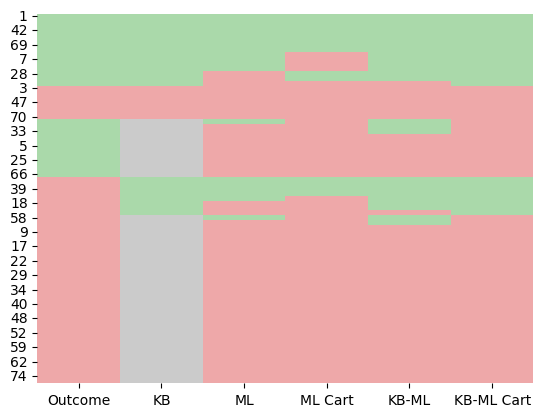

In [46]:
outcomes = pd.DataFrame(res_list[exp], columns = ["Outcome", "KB", "ML", "ML Cart", "KB-ML", "KB-ML Cart"])
outcomes = outcomes.round()#.astype('Int64') 
#outcomes.replace('<NA>', np.nan, inplace=True)
outcomes["EQ"] = outcomes["Outcome"]==outcomes["KB"]
outcomes = outcomes.sort_values(['EQ','Outcome','KB','KB-ML','ML','ML Cart','KB-ML Cart'], ascending=[False,False,False,False,False,False,False])
outcomes = outcomes.fillna(0.5)
outcomes.head()

c = sns.color_palette()
cmap = LinearSegmentedColormap.from_list('rg',[c[3], c[7], c[2]], N=256) 
sns.heatmap(outcomes.drop(columns = "EQ"), cmap=cmap, cbar=False, alpha = 0.4)

#### EXAMPLES from Federico

In [331]:
x, y = load_iris(return_X_y=True, as_frame=True)
x.columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
y = pd.DataFrame(y).replace({"target": {0: 'setosa', 1: 'versicolor', 2: 'virginica'}})
dataset = x.join(y)
dataset.columns = [*dataset.columns[:-1], 'iris']

In [332]:
train, test = train_test_split(dataset, test_size=0.25, random_state=1)

In [333]:
predictor = MLPClassifier(alpha=1, max_iter=1000)
#predictor = KNeighborsClassifier(n_neighbors=7)
#predictor = DecisionTreeClassifier()
predictor.fit(train.iloc[:, :-1], train.iloc[:, -1])
print(f'Accuracy: {accuracy_score(predictor.predict(test.iloc[:, :-1]), test.iloc[:, -1]):.2f}')
print(f'F1: {f1_score(predictor.predict(test.iloc[:, :-1]), test.iloc[:, -1], average="weighted"):.2f}')

Accuracy: 1.00
F1: 1.00


In [334]:
cart = Extractor.cart(predictor, simplify=True)
theory_from_cart = cart.extract(train)
scores, completeness = get_scores(cart, test, predictor)
print(f'CART performance ({cart.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nCART extracted rules:\n\n' + pretty_theory(theory_from_cart))

CART performance (3 rules with 100.00% coverage):
Classification accuracy = 0.97 (data), 0.97 (BB)
F1 = 0.97 (data), 0.97 (BB)

CART extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength =< 2.6.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength =< 4.75.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica).


In [337]:
# Feature ranker serve a stimare quanto sono importanti le feature di input rispetto alle predizioni
# le stime sono normalizzate in [0, 1]
ranked = FeatureRanker(x.columns).fit(predictor, x).rankings()

# GridEx ti divide lo spazio di input in ipercubi secondo le istruzioni della griglia
# Grid(n, strategy) vuol dire che vengono eseguite n ricorsioni con la strategia specificata
# strategy può essere FixedStrategy(k) che divide TUTTE le variabili in k partizioni, ad ogni ricorsione
# oppure AdaptiveStrategy(ranked, [(i, k)]) che divide in k partizioni tutte le variabili con importanza > i
# puoi anche fare cose piu' complesse, tipo AdaptiveStrategy(ranked, [(0.5, 3), (0.8, 5)])
# threshold e' l'errore di classificazione ammesso. Ma credo che per classificazione non venga preso in considerazione
# min_examples sono gli esempi da creare random in ogni partizione creata per avere maggiore stabilita'
gridEx = Extractor.gridex(predictor, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=50)
theory_from_gridEx = gridEx.extract(train)
scores, completeness = get_scores(gridEx, test, predictor)
print(f'GridEx performance ({gridEx.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nGridEx extracted rules:\n\n' + pretty_theory(theory_from_gridEx))

print()

# HEx fa la stessa cosa ma in maniera gerarchica. Stessi parametri
HEx = Extractor.hex(predictor, Grid(1, AdaptiveStrategy(ranked, [(0.5, 3)])), threshold=.1, min_examples=1)
theory_from_HEx = HEx.extract(train)
scores, completeness = get_scores(HEx, test, predictor)
print(f'HEx performance ({HEx.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nHEx extracted rules:\n\n' + pretty_theory(theory_from_HEx))

print()

# CReEPy utilizza clustering (Clustering.exact oppure Clustering.cream)
# depth e' la profondita' di ricorsione, error_threshold come sopra
# ignore_threshold e' per eliminare dalle regole tutte le variabili con importanza inferiore alla threshold
CReEPy = Extractor.creepy(predictor, depth=2, error_threshold=.1, seed=123, output=Target.CLASSIFICATION,
                          clustering=Clustering.exact, ignore_threshold=.5, ranks=ranked)
theory_from_CReEPy = CReEPy.extract(train)
scores, completeness = get_scores(CReEPy, test, predictor)
print(f'CReEPy performance ({CReEPy.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nCReEPy extracted rules:\n\n' + pretty_theory(theory_from_CReEPy))

GridEx performance (3 rules with 100.00% coverage):
Classification accuracy = 0.97 (data), 0.97 (BB)
F1 = 0.97 (data), 0.97 (BB)

GridEx extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength =< 2.96, PetalWidth =< 0.89.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.96, 4.93], PetalWidth > 0.89.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    PetalLength > 4.93, PetalWidth > 0.89.

HEx performance (4 rules with 100.00% coverage):
Classification accuracy = 0.97 (data), 0.97 (BB)
F1 = 0.97 (data), 0.97 (BB)

HEx extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength =< 2.96, PetalWidth > 1.70.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength =< 2.96, PetalWidth =< 1.70.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.96, 4.93], PetalWidth =< 1.70.
ir

In [94]:
# se vuoi fare tuning automatico di GridEx ed HEx puoi usare PEDRO

from psyke.tuning import Objective
from psyke.tuning.pedro import PEDRO

pedro = PEDRO(predictor, train, max_error_increase=1.2, min_rule_decrease=0.9, readability_tradeoff=0.1, max_depth=1,
              patience=1, algorithm=PEDRO.Algorithm.HEX, objective=Objective.MODEL, output=Target.CLASSIFICATION)
pedro.search()
(_, _, threshold, grid) = pedro.get_best()[0]

hEx = Extractor.hex(predictor, grid, threshold=threshold)
theory_from_HEx = hEx.extract(train)
scores, completeness = get_scores(hEx, test, predictor)
print(f'HEx performance ({hEx.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nHEx extracted rules:\n\n' + pretty_theory(theory_from_HEx))

HEx. Grid (1). Fixed (2). Threshold = 0.02. MAE = 0.24, 9 rules
HEx. Grid (1). Fixed (2). Threshold = 0.04. MAE = 0.24, 9 rules

HEx. Grid (1). Fixed (3). Threshold = 0.02. MAE = 0.06, 23 rules
HEx. Grid (1). Fixed (3). Threshold = 0.04. MAE = 0.06, 23 rules

HEx. Grid (1). Adaptive ([(0.99, 2)]). Threshold = 0.02. MAE = 0.29, 2 rules
HEx. Grid (1). Adaptive ([(0.99, 2)]). Threshold = 0.04. MAE = 0.29, 2 rules

HEx. Grid (1). Adaptive ([(0.67, 2)]). Threshold = 0.02. MAE = 0.24, 4 rules
HEx. Grid (1). Adaptive ([(0.67, 2)]). Threshold = 0.04. MAE = 0.24, 4 rules

HEx. Grid (1). Adaptive ([(0.99, 3)]). Threshold = 0.02. MAE = 0.06, 3 rules
HEx. Grid (1). Adaptive ([(0.99, 3)]). Threshold = 0.04. MAE = 0.06, 3 rules

HEx. Grid (1). Adaptive ([(0.67, 3)]). Threshold = 0.02. MAE = 0.06, 3 rules
HEx. Grid (1). Adaptive ([(0.67, 3)]). Threshold = 0.04. MAE = 0.06, 3 rules

HEx. Grid (1). Adaptive ([(0.99, 5)]). Threshold = 0.02. MAE = 0.06, 3 rules
HEx. Grid (1). Adaptive ([(0.99, 5)]). Thre

In [95]:
# se vuoi usare DiViNE hai due parametri da tunare, ovvero k e patience
# puoi metterli in un ciclo e vedere come ti cambia l'accuracy

divine = Extractor.divine(predictor, k=5, patience=5, close_to_center=False)
theory_from_divine = divine.extract(train)
scores, completeness = get_scores(divine, test, predictor)
print(f'DiViNE performance ({divine.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nDiViNE extracted rules:\n\n' + pretty_theory(theory_from_divine))

DiViNE performance (3 rules with 76.32% coverage):
Classification accuracy = 0.97 (data), 1.00 (BB)
F1 = 0.97 (data), 1.00 (BB)

DiViNE extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    SepalLength in [4.9, 7.0], SepalWidth in [2.0, 3.2], PetalLength in [3.3, 4.9], PetalWidth in [1.0, 1.5].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    SepalLength =< 5.7, SepalWidth > 2.3, PetalLength =< 1.9, PetalWidth in [0.1, 0.6].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    SepalLength > 5.6, SepalWidth in [2.5, 3.8], PetalLength > 4.8, PetalWidth > 1.4.


In [96]:
# con CRASH puoi fare tuning di CReEPy
crash = CRASH(predictor, dataframe=train, output=Target.CLASSIFICATION, max_error_increase=1.2, min_rule_decrease=0.9,
              readability_tradeoff=0.1, patience=5, max_depth=3, max_gauss_components=10)
crash.search()
(_, _, depth, threshold, components, algorithm) = crash.get_best()[0]

creepy = Extractor.creepy(predictor, depth=depth, error_threshold=threshold, output=Target.CLASSIFICATION,
                          ranks=FeatureRanker(x.columns).fit(predictor, x).rankings(), ignore_threshold=.99,
                          clustering=Clustering.exact if algorithm == CRASH.Algorithm.ExACT else Clustering.cream)
theory_from_creepy = creepy.extract(train)
scores, completeness = get_scores(creepy, test, predictor)
print(f'CReEPy performance ({creepy.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nCReEPy extracted rules:\n\n' + pretty_theory(theory_from_creepy))

Algorithm.ExACT. Depth: 1. Threshold = 1.00. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 1. Threshold = 0.02. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 1. Threshold = 0.06. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 1. Threshold = 0.11. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 1. Threshold = 0.15. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 1. Threshold = 0.20. Gaussian components = 2. Predictive loss = 0.30, 2 rules

Algorithm.ExACT. Depth: 2. Threshold = 1.00. Gaussian components = 2. Predictive loss = 0.30, 2 rules
Algorithm.ExACT. Depth: 2. Threshold = 0.02. Gaussian components = 2. Predictive loss = 0.10, 3 rules
Algorithm.ExACT. Depth: 2. Threshold = 0.06. Gaussian components = 2. Predictive loss = 0.10, 3 rules
Algorithm.ExACT. Depth: 2. Threshold = 0.11. Gaussian components = 2. Predictive 

In [11]:
it = Extractor.iter(predictor, min_update=0.2, min_examples=150, threshold=0.1, max_iterations=600, n_points=1)
theory_from_iter = it.extract(train)
scores, completeness = get_scores(it, test, predictor)
print(f'ITER performance ({it.n_rules} rules with {completeness * 100:.2f}% coverage):')
print_scores(scores)
print('\nITER extracted rules:\n\n' + pretty_theory(theory_from_iter))

ITER performance (3 rules with 100.00% coverage):
Classification accuracy = 0.97 (data), 1.00 (BB)
F1 = 0.97 (data), 1.00 (BB)

ITER extracted rules:

iris(PetalLength, PetalWidth, SepalLength, SepalWidth, setosa) :-
    PetalLength =< 2.58.
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, versicolor) :-
    PetalLength in [2.58, 4.94].
iris(PetalLength, PetalWidth, SepalLength, SepalWidth, virginica) :-
    PetalLength > 4.94.
